In [52]:
!pip install transformers

In [53]:
# Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Tokenize to add stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Data loading utility
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split


from torch.optim import AdamW
# Models
from torch import nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_error()

# Training
from torch import optim

# Evaluation
from sklearn.metrics import accuracy_score, matthews_corrcoef

%matplotlib inline

# specify GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
import pandas as pd
import yfinance as yf
import datetime

# Downloading FTSE100 stocks data
ftse100_stocks = yf.download("SBIN.NS JIOFIN.NS AXS ADANIPORTS.NS PANW", start=datetime.datetime(2019, 1, 1),
                             end=datetime.datetime(2024,3,12), group_by='tickers')

# Save DataFrame to a pickle file
ftse100_stocks.to_pickle('aqr_stocks.pkl')

[*********************100%***********************]  5 of 5 completed


In [55]:
article_sentiments = pd.read_pickle('aqr_stocks.pkl')
article_sentiments

Ticker         SBIN.NS                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2019-01-01  280.020177  283.032170  276.584641  281.996796  11837127.0   
2019-01-02  281.526196  284.726421  275.878730  276.631714  25559853.0   
2019-01-03  277.667094  278.184767  273.055002  273.996246  17548347.0   
2019-01-04  274.937482  281.432063  274.372730  280.161377  19514041.0   
2019-01-07  283.361597  283.785168  277.855340  278.890686  14579399.0   
...                ...         ...         ...         ...         ...   
2024-03-05  756.808577  773.970784  756.415150  771.020264  18088847.0   
2024-03-06  770.725193  777.265477  760.152494  770.971069  26710525.0   
2024-03-07  776.970463  780.314410  770.085914  775.052612  15497868.0   
2024-03-08         NaN         NaN         NaN         NaN         NaN   
2024-03-11  776.970482  779.724290  757.841260  760.939331  16778340.0   

Ticker            PANW                                                  ...  \
Price             Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2019-01-01         NaN         NaN         NaN         NaN         NaN  ...   
2019-01-02   30.840000   31.195000   30.320000   30.535000   8865600.0  ...   
2019-01-03   30.228333   30.480000   29.799999   29.950001   6227400.0  ...   
2019-01-04   30.343332   31.021667   30.270000   30.731667   6733800.0  ...   
2019-01-07   30.879999   31.333332   30.786667   31.225000   7000800.0  ...   
...                ...         ...         ...         ...         ...  ...   
2024-03-05  147.945007  148.774994  142.339996  145.565002  14534200.0  ...   
2024-03-06  149.490005  150.000000  138.404999  139.429993  23383400.0  ...   
2024-03-07  140.000000  144.065002  138.875000  143.244995  16056600.0  ...   
2024-03-08  143.089996  144.225006  139.850006  140.100006  11484800.0  ...   
2024-03-11  139.149994  143.399994  138.804993  141.664993   9898200.0  ...   

Ticker            AXS                                              \
Price            Open       High        Low      Close     Volume   
Date                                                                
2019-01-01        NaN        NaN        NaN        NaN        NaN   
2019-01-02  42.692841  43.120106  42.433133  42.784996   968700.0   
2019-01-03  42.542041  43.136861  42.525285  42.684464   844500.0   
2019-01-04  43.170364  44.753751  43.069832  44.669975  1003200.0   
2019-01-07  44.401878  44.879408  44.158924  44.217567   635500.0   
...               ...        ...        ...        ...        ...   
2024-03-05  58.968693  59.654035  58.968693  59.438641   570200.0   
2024-03-06  59.693199  60.075031  58.802256  59.409271   669600.0   
2024-03-07  59.409272  59.898802  59.252623  59.663826   435500.0   
2024-03-08  59.644243  60.319795  59.526757  59.898800   432300.0   
2024-03-11  59.751939  60.427492  59.751939  60.192516   520700.0   

Ticker     ADANIPORTS.NS                                                    
Price               Open         High          Low        Close     Volume  
Date                                                                        
2019-01-01    372.497654   376.933304   370.328046   375.101196  1233249.0  
2019-01-02    374.136893   375.052961   364.494189   367.676270  1506543.0  
2019-01-03    368.737019   371.533397   363.144262   364.590668  1902063.0  
2019-01-04    365.120964   370.231615   362.421019   368.495911  1669709.0  
2019-01-07    371.244136   373.124476   365.796014   368.013824  1260331.0  
...                  ...          ...          ...          ...        ...  
2024-03-05   1338.308077  1349.161413  1328.300963  1332.582642  1815438.0  
2024-03-06   1336.963689  1338.855597  1298.429072  1319.140259  2758443.0  
2024-03-07   1324.118867  1329.645083  130

In [56]:
article_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1347 entries, 2019-01-01 to 2024-03-11
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (SBIN.NS, Open)          1283 non-null   float64
 1   (SBIN.NS, High)          1283 non-null   float64
 2   (SBIN.NS, Low)           1283 non-null   float64
 3   (SBIN.NS, Close)         1283 non-null   float64
 4   (SBIN.NS, Volume)        1283 non-null   float64
 5   (PANW, Open)             1306 non-null   float64
 6   (PANW, High)             1306 non-null   float64
 7   (PANW, Low)              1306 non-null   float64
 8   (PANW, Close)            1306 non-null   float64
 9   (PANW, Volume)           1306 non-null   float64
 10  (JIOFIN.NS, Open)        136 non-null    float64
 11  (JIOFIN.NS, High)        136 non-null    float64
 12  (JIOFIN.NS, Low)         136 non-null    float64
 13  (JIOFIN.NS, Close)       136 non-null    float64
 14  (JIOFI

In [57]:
!pip install pandas
import pandas as pd
article_sentiments = pd.DataFrame({'Label': [0, 1, 0, 1, 1]})

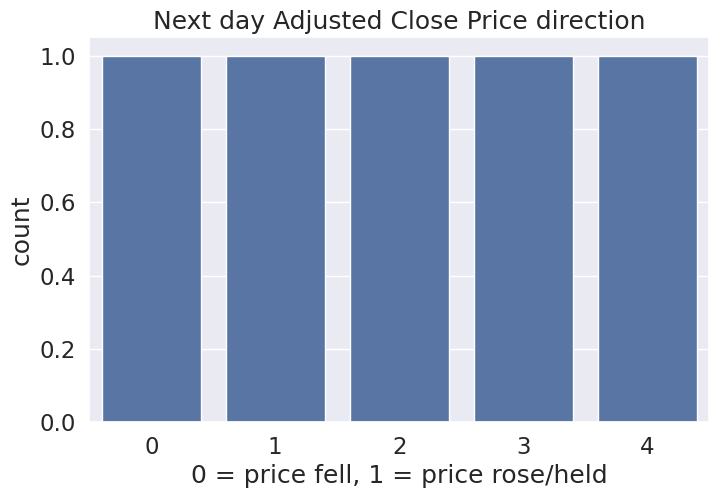

In [58]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(article_sentiments.Label)
plt.title('Next day Adjusted Close Price direction')
plt.xlabel('0 = price fell, 1 = price rose/held');

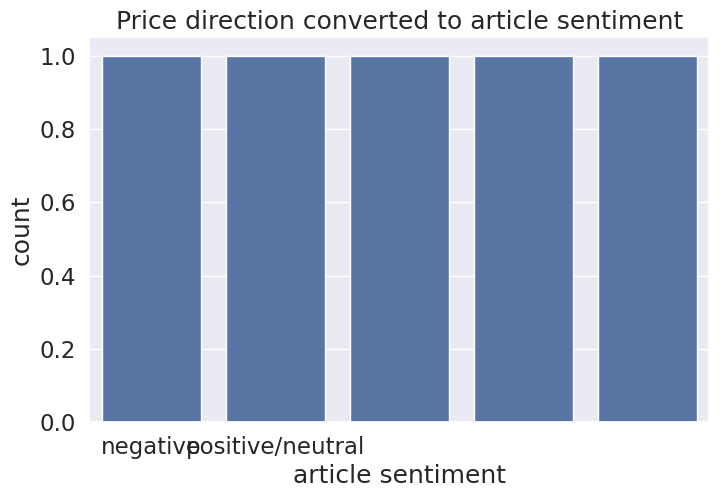

In [59]:
# Plot showing Adjusted Close prices converted to sentiment

def to_sentiment(label):
  label = int(label)
  if label == 0:
    return 0
  else:
    return 1

article_sentiments['sentiment'] = article_sentiments.Label.apply(to_sentiment)

class_names = ['negative', 'positive/neutral']

# Plot the counts of observations in each categorical bin
ax = sns.countplot(article_sentiments.sentiment)

# Label the plot
plt.title('Price direction converted to article sentiment')
plt.xlabel('article sentiment')
ax.set_xticklabels(class_names);

In [60]:
pip install nltk Googlenews newspaper3k wordcloud

In [61]:
pip install lxml[html_clean]

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [63]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
company_name = input("Please provide the name of the Company or a Ticker: ")
if company_name != '':
    print(f'Searching for and analyzing {company_name}, Please be patient, it might take a while...')
    googlenews = GoogleNews(start=yesterday,end=now)
    googlenews.search(company_name)
    result = googlenews.result()
    df = pd.DataFrame(result)
    print(df)


Please provide the name of the Company or a Ticker: indusind
Searching for and analyzing indusind, Please be patient, it might take a while...
                                               title               media  \
0  IndusInd Bank (NSE:INDUSINDBK) stock performs ...  Simply Wall Street   
1  IndusInd Bank’s BCA tied to asset quality, liq...        Moneycontrol   
2  IndusInd Bank Share Price Today: Minor Dip, Ke...    Hindustan Herald   
3  IndusInd Bank shares in focus after clarificat...  The Economic Times   
4  Stocks to watch on April 25: RIL, Axis Bank, G...                 MSN   
5  Stocks to watch on April 25: RIL, Axis Bank, G...         India Today   
6  Business News | ⚡Axis Bank, Tech Mahindra, Ind...            LatestLY   
7  Stocks in news: Maruti Suzuki, RIL, Tech Mahin...  The Economic Times   
8  FPIs increase IndusInd Bank stake by 5.24%, DI...            BizzBuzz   
9  NSE/BSE, Top Gainers & Top Losers Today 24 Apr...        BusinessLine   

          date      

In [65]:
try:
    list =[]
    for i in df.index:
        dict = {}
        article = Article(df['link'][i],config=config) #providing the link
        try:
          article.download()
          article.parse()
          article.nlp()
        except:
           pass
        dict['Date']=df['date'][i]
        dict['Media']=df['media'][i]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        list.append(dict)
    check_empty = not any(list)
    # print(check_empty)
    if check_empty == False:
      news_df=pd.DataFrame(list) #creating dataframe
      print(news_df)

except Exception as e:
    #exception handling
    print("exception occurred:" + str(e))
    print('Looks like, there is some error in retrieving the data, Please try again or try with a different ticker.' )


          Date               Media  \
0  7 hours ago  Simply Wall Street   
1    1 day ago        Moneycontrol   
2    1 day ago    Hindustan Herald   
3    1 day ago  The Economic Times   
4    1 day ago                 MSN   
5    1 day ago         India Today   
6    1 day ago            LatestLY   
7    1 day ago  The Economic Times   
8    1 day ago            BizzBuzz   
9    1 day ago        BusinessLine   

                                               Title  \
0  IndusInd Bank (NSE:INDUSINDBK) stock performs ...   
1  Latest NSE, BSE, Business News, Stock/Share Ti...   
2                                                      
3                                                      
4                                                MSN   
5  Stocks to watch on April 25: RIL, Axis Bank, G...   
6                                                      
7                                                      
8                                                      
9  NSE/BSE, Top Gaine

In [66]:
news_df

,Date,Media,Title,Article,Summary,Key_words
0,7 hours ago,Simply Wall Street,IndusInd Bank (NSE:INDUSINDBK) stock performs ...,IndusInd Bank Limited ( ) shareholders might b...,,"[indusind, market, price, better, long, term, ..."
1,1 day ago,Moneycontrol,"Latest NSE, BSE, Business News, Stock/Share Ti...",Indusind Bank S Bca Tied To Asset Quality Liqu...,,"[indusind, content, stockshare, sensex, bank, ..."
2,1 day ago,Hindustan Herald,,,,[]
3,1 day ago,The Economic Times,,,,[]
4,1 day ago,MSN,MSN,,,[msn]
5,1 day ago,India Today,"Stocks to watch on April 25: RIL, Axis Bank, G...",Dalal Street ended its 7-day winning run on a ...,,"[ril, indusind, stocks, 25, rs, quarter, stock..."
6,1 day ago,LatestLY,,,,[]
7,1 day ago,The Economic Times,,,,[]
8,1 day ago,BizzBuzz,,,,[]
9,1 day ago,BusinessLine,"NSE/BSE, Top Gainers & Top Losers Today 24 Apr...","Shares of IndusInd Bank Ltd, Ultratech Cement ...",,"[losers, indusind, recent, today, points, ultr..."


Positive Sentiment: 3.00
Neutral Sentiment: 7.00
Negative Sentiment: 0.00


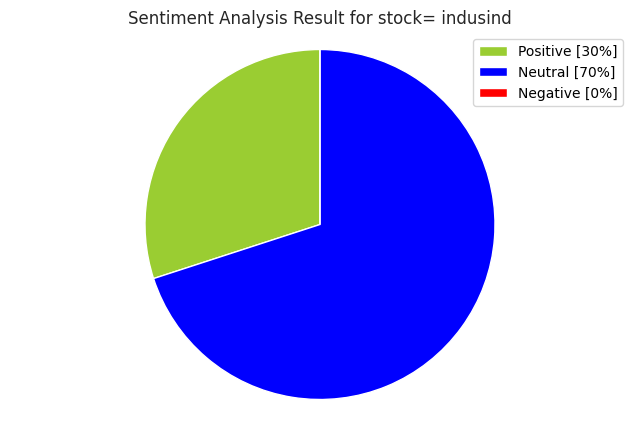

Wordcloud for indusind


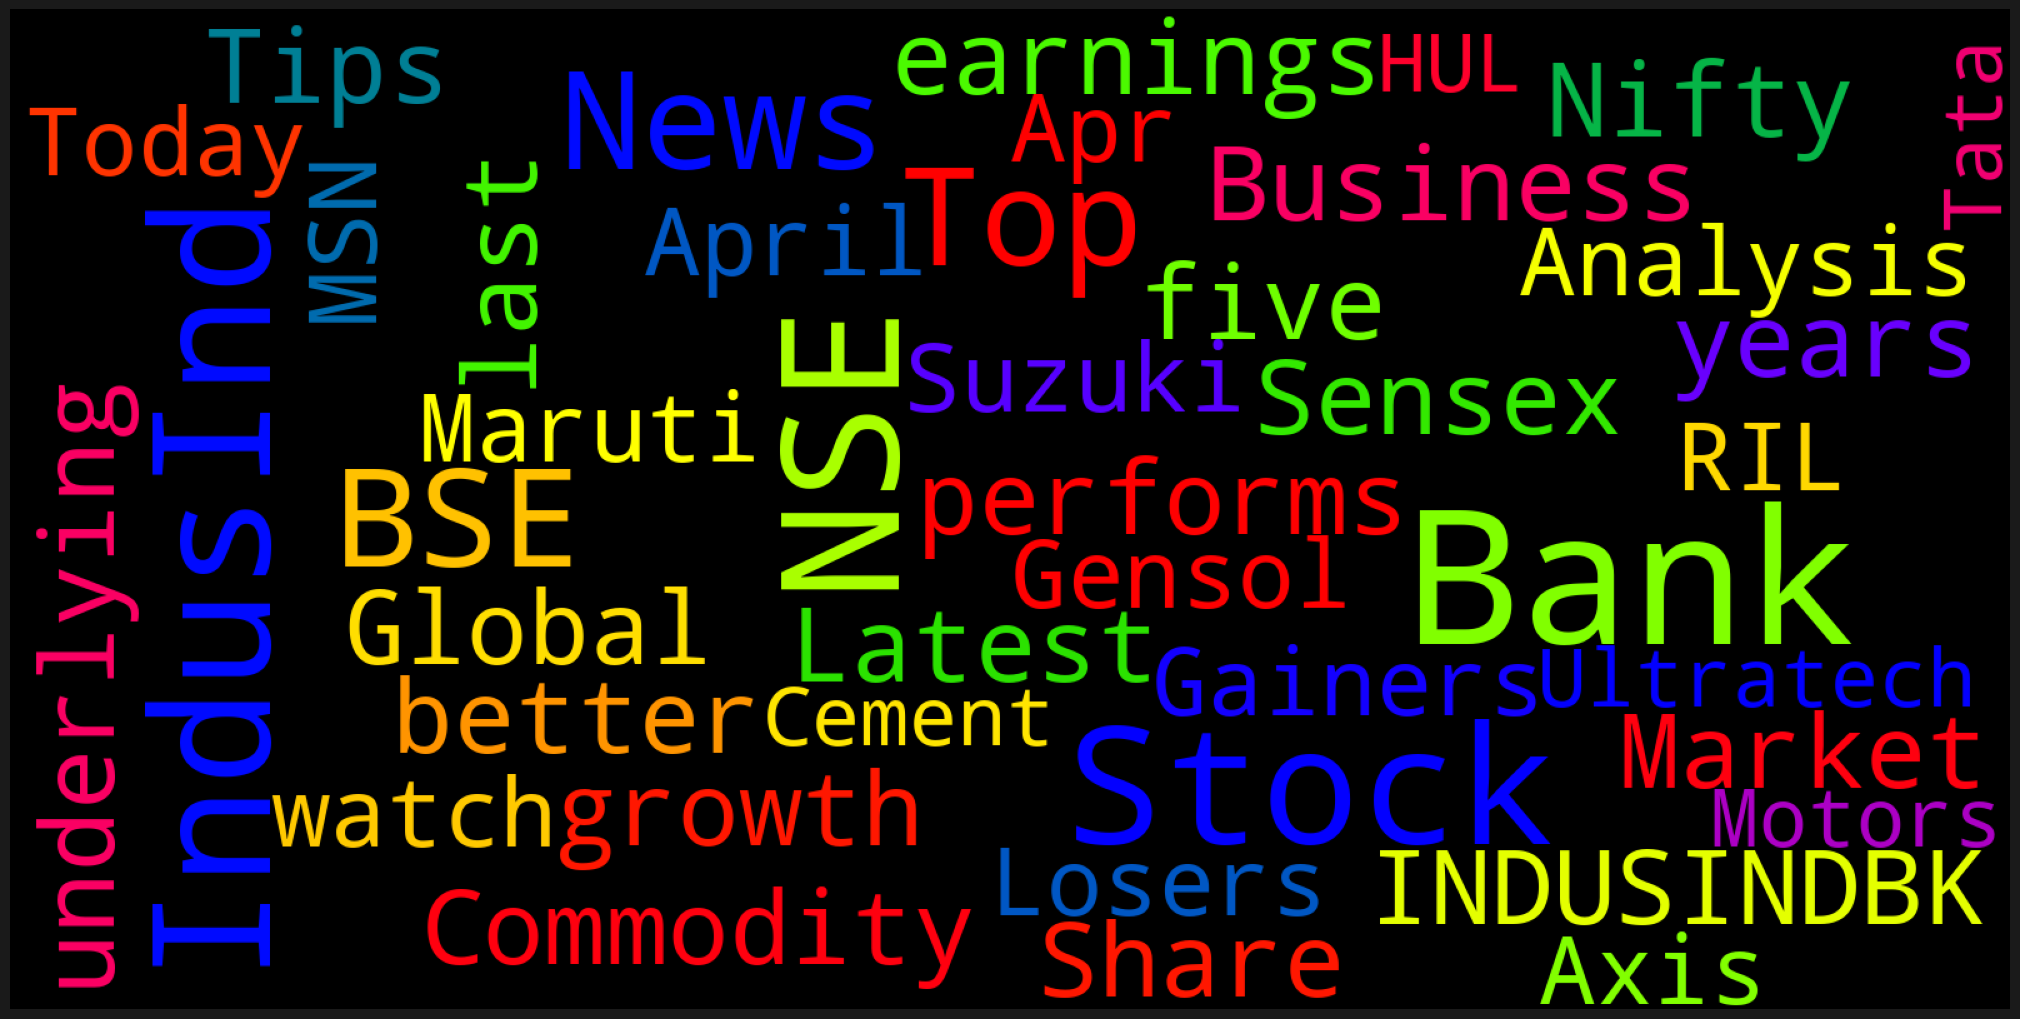

In [67]:

def percentage(part,whole):
    return 100 * float(part)/float(whole)


positive = 0
negative = 0
neutral = 0

news_list = []
neutral_list = []
negative_list = []
positive_list = []


for news in news_df['Title']:
    news_list.append(news)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
    neg = analyzer['neg']
    neu = analyzer['neu']
    pos = analyzer['pos']
    comp = analyzer['compound']

    if neg > pos:
        negative_list.append(news)
        negative += 1
    elif pos > neg:
        positive_list.append(news)
        positive += 1
    elif pos == neg:
        neutral_list.append(news)
        neutral += 1

positive = percentage(positive, len(news_df))
negative = percentage(negative, len(news_df))
neutral = percentage(neutral, len(news_df))


news_list = pd.DataFrame(news_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print("Positive Sentiment:", '%.2f' % len(positive_list), end='\n')
print("Neutral Sentiment:", '%.2f' % len(neutral_list), end='\n')
print("Negative Sentiment:", '%.2f' % len(negative_list), end='\n')

#Creating PieCart
labels = ['Positive ['+str(round(positive))+'%]' , 'Neutral ['+str(round(neutral))+'%]','Negative ['+str(round(negative))+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for stock= "+company_name+"" )
plt.axis('equal')
plt.show()

# Word cloud visualization
def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + company_name)
word_cloud(news_df['Title'].values)
